In [ ]:
%%bash
# Create the conda environment from environment.yml (run in a terminal or notebook).
# This will create an env named 'soundanalyzer' with the required packages.
conda env create -f environment.yml || conda env update -f environment.yml
# After creating/updating the env, register the kernel (run in the terminal):
# conda activate soundanalyzer
# python -m ipykernel install --user --name soundanalyzer --display-name "Python (soundanalyzer)"
# Note: running conda env changes from inside an active kernel may not affect the current kernel session.


In [1]:
import numpy as np
import scipy.ndimage
import scipy.signal

class ERBSpectralProcessor:
    def __init__(self, sample_rate=44100, fft_size=4096, num_bands=60):
        self.sr = sample_rate
        self.fft_size = fft_size
        self.num_bands = num_bands  # Resolución visual (cuantas barras verás)
        
        # 1. Pre-calcular frecuencias FFT
        self.fft_freqs = np.fft.rfftfreq(fft_size, d=1/sample_rate)
        
        # 2. Construir el Banco de Filtros ERB
        self.filter_bank, self.center_freqs_hz = self._create_erb_filter_bank()
        
        # 3. Curva de Tilt (-3dB/oct compensación rosa)
        valid_freqs = np.maximum(self.fft_freqs, 1.0)
        self.tilt_curve = 3 * np.log2(valid_freqs)
        self.tilt_curve -= self.tilt_curve[0]

    def _hz_to_erb(self, freqs):
        return 21.4 * np.log10(0.00437 * freqs + 1)

    def _erb_to_hz(self, erb_nums):
        return (10**(erb_nums / 21.4) - 1) / 0.00437

    def _create_erb_filter_bank(self):
        min_freq = 20
        max_freq = self.sr / 2
        low_erb = self._hz_to_erb(min_freq)
        high_erb = self._hz_to_erb(max_freq)
        erb_points = np.linspace(low_erb, high_erb, self.num_bands + 2)
        hz_points = self._erb_to_hz(erb_points)
        bins = np.floor((self.fft_size + 1) * hz_points / self.sr).astype(int)
        
        fbank = np.zeros((self.num_bands, len(self.fft_freqs)))
        for m in range(1, self.num_bands + 1):
            f_m_minus, f_m, f_m_plus = bins[m-1], bins[m], bins[m+1]
            for k in range(f_m_minus, f_m):
                fbank[m-1, k] = (k - f_m_minus) / (f_m - f_m_minus)
            for k in range(f_m, f_m_plus):
                fbank[m-1, k] = (f_m_plus - k) / (f_m_plus - f_m)
        return fbank, hz_points[1:-1]

    def process_frame(self, audio_chunk, floor_factor=0.5):
        # Windowing y FFT
        window = np.hanning(len(audio_chunk))
        fft_raw = np.abs(np.fft.rfft(audio_chunk * window, n=self.fft_size))
        
        # Tilt Compensation (Lineal)
        tilt_linear = 10 ** (self.tilt_curve / 20)
        compensated_linear = fft_raw * tilt_linear
        
        # Conversión a dB para Noise Floor
        spectrum_db = 20 * np.log10(compensated_linear + 1e-9)
        
        # Noise Spectral Floor (Estimación del ruido de fondo)
        floor_db = scipy.ndimage.median_filter(spectrum_db, size=30)
        clean_db = spectrum_db - (floor_db * floor_factor)
        
        # Volver a lineal para sumar en bandas ERB
        clean_linear = 10**(clean_db / 20)
        
        # Suavizado ERB (Integración de energía)
        erb_energy = np.dot(self.filter_bank, clean_linear)
        erb_db = 20 * np.log10(erb_energy + 1e-9)

        return self.center_freqs_hz, erb_db

🎙️ GRABANDO (1.0s)...


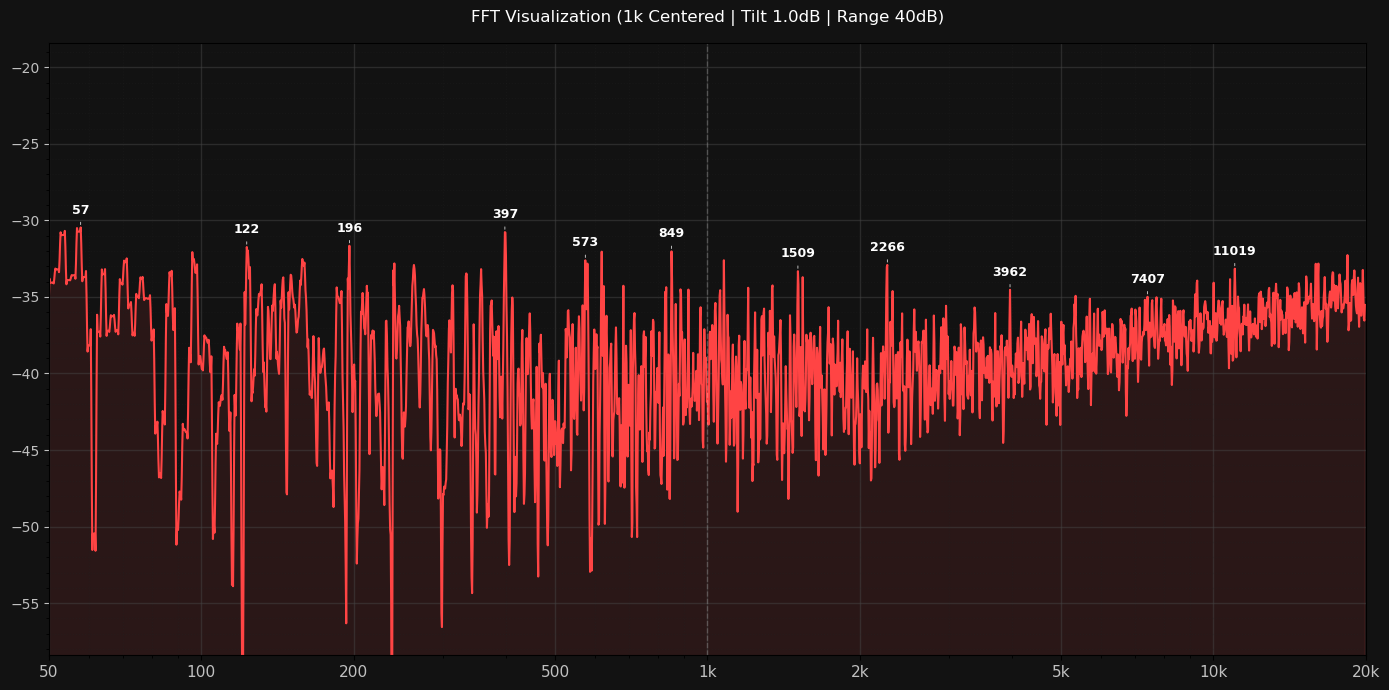

In [40]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import sounddevice as sd
from matplotlib.ticker import ScalarFormatter

# --- PARÁMETROS PROFESIONALES ---
FS = 44100
DURATION = 1.0      
FFT_SIZE = 32768    
TILT_DB = 1.0       
BANDS_PER_OCTAVE = 288 

# --- 1. GRABACIÓN ---
print(f"🎙️ GRABANDO ({DURATION}s)...")
audio_data = sd.rec(int(DURATION * FS), samplerate=FS, channels=1, dtype='float32')
sd.wait()
audio_flat = audio_data.flatten()

# --- 2. MOTOR MATEMÁTICO (Igual al anterior) ---
def compute_fractional_octave_spectrum(audio_chunk, sr, fft_size, bands_per_oct=48):
    window = scipy.signal.get_window('blackmanharris', len(audio_chunk))
    fft_raw = np.abs(np.fft.rfft(audio_chunk * window, n=fft_size))
    freqs_lin = np.fft.rfftfreq(fft_size, d=1/sr)
    
    f_min, f_max = 30.0, 20000.0
    num_bands = int(np.log2(f_max / f_min) * bands_per_oct)
    bands_centers = f_min * (2 ** (np.arange(num_bands) / bands_per_oct))
    
    spectrum_log = np.zeros(num_bands)
    
    for i, center in enumerate(bands_centers):
        fd = 2 ** (1 / (2 * bands_per_oct))
        lower_f = center / fd
        upper_f = center * fd
        idx_start = np.searchsorted(freqs_lin, lower_f)
        idx_end = np.searchsorted(freqs_lin, upper_f)
        
        if idx_end > idx_start:
            spectrum_log[i] = np.max(fft_raw[idx_start:idx_end])
        else:
            idx_nearest = np.clip(np.searchsorted(freqs_lin, center), 0, len(fft_raw)-1)
            spectrum_log[i] = fft_raw[idx_nearest]
            
    log_db = 20 * np.log10(spectrum_log + 1e-12)
    tilt_curve = TILT_DB * np.log2(bands_centers / 1000.0)
    log_db += tilt_curve
    
    return bands_centers, log_db

# --- 3. PROCESAMIENTO ---
num_chunks = len(audio_flat) // FFT_SIZE
peak_spectrum_db = None
bands_x = None

for i in range(num_chunks):
    chunk = audio_flat[i*FFT_SIZE : (i+1)*FFT_SIZE]
    if len(chunk) < FFT_SIZE: continue
    
    bx, bdb = compute_fractional_octave_spectrum(chunk, FS, FFT_SIZE, BANDS_PER_OCTAVE)
    bands_x = bx
    
    if peak_spectrum_db is None:
        peak_spectrum_db = bdb
    else:
        peak_spectrum_db = np.maximum(peak_spectrum_db, bdb)

final_curve = scipy.signal.savgol_filter(peak_spectrum_db, window_length=5, polyorder=2)
peaks, _ = scipy.signal.find_peaks(final_curve, distance=int(BANDS_PER_OCTAVE/2), prominence=5)

# --- 5. VISUALIZACIÓN CENTRADA EN 1K ---
fig, ax = plt.subplots(figsize=(14, 7), facecolor='#121212')
ax.set_facecolor('#121212')

ax.plot(bands_x, final_curve, color='#ff4444', linewidth=1.5, label='Max-Pool Spectrum')
ax.fill_between(bands_x, final_curve, -140, color='#ff4444', alpha=0.1)

for i in peaks:
    freq_val = bands_x[i]
    db_val = final_curve[i]
    if db_val > -50: 
        ax.annotate(f"{int(freq_val)}", xy=(freq_val, db_val), 
                     xytext=(0, 10), textcoords='offset points', ha='center', 
                     color='white', fontsize=9, fontweight='bold',
                     arrowprops=dict(arrowstyle='-', color='white', lw=0.5))

# --- EJE X: CENTRADO EXACTO EN 1K ---
ax.set_xscale('log')

# Definimos los límites para forzar que 1k esté en el centro geométrico
# sqrt(50 * 20000) = 1000 Hz exactos.
LIMIT_LOW = 50
LIMIT_HIGH = 20000
ax.set_xlim(LIMIT_LOW, LIMIT_HIGH)

# Ticks ajustados para simetría visual
ticks_major = [50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000]
ax.set_xticks(ticks_major)
ax.get_xaxis().set_major_formatter(ScalarFormatter())
# Etiquetas personalizadas limpias
ax.set_xticklabels(['50', '100', '200', '500', '1k', '2k', '5k', '10k', '20k'], color='silver', fontsize=11)

# Grid
ax.grid(which='major', color='#444444', linestyle='-', linewidth=1.0, alpha=0.5)
ax.grid(which='minor', color='#222222', linestyle=':', linewidth=0.8, alpha=0.3)
ax.minorticks_on()

# --- AJUSTE VERTICAL (ZOOM 40dB) ---
signal_median = np.median(final_curve)
visible_range_db = 40 
y_min = signal_median - (visible_range_db / 2)
y_max = signal_median + (visible_range_db / 2)
ax.set_ylim(y_min, y_max)
ax.tick_params(axis='y', colors='silver')

# Línea guía central en 1k (opcional, para verificar)
ax.axvline(1000, color='white', linestyle='--', alpha=0.2, linewidth=1)

plt.title(f"FFT Visualization (1k Centered | Tilt {TILT_DB}dB | Range {visible_range_db}dB)", color='white', pad=15)
plt.tight_layout()
plt.show()